In [25]:


#The main file for case 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Path to main file
file_Moa = "/Users/moasjoberg/Documents/Turbulence_cource/Turbulence_course/FALL2_1.TXT"


# Read as space-separated values
df = pd.read_csv(file_Moa, delim_whitespace=True, header=None)




#retrieve variables
R = df.iloc[:, 8].to_numpy()  # Nettradiationn in column 23 W/m2
G= df.iloc[:, 9] # GROUND HEAT FLUX AT EACH HEGHT in column 18-22 (22 INCLUDED) W/m2
p=df.iloc[:, 7].to_numpy()  # air pressure #hpa
theta= df.iloc[:, 5].to_numpy()  # Potential temperature at height
r= df.iloc[:,6].to_numpy() #relative humidity at height 2
u= df.iloc[:,4].to_numpy() #windspeed at height 10.1m 

#Constants
rho =  1.225 # kg/m³ - density of air at sea level (is it always the same?)
c_p= 1005 # J/(kg·K) specific heat of air at sea level
gamma= (c_p * p /10) / (0.622 * 2.45)# 0.665 # kPa /K - psycometric constant γ=cp⋅P/ (ε⋅λ)  (lambda is latent heat of vaporization, epsilon molecular weight of water vapor to dry air)
r_l = 100 #s m^-1 stomatal resistance of single leaf (well watered condition)
karman= 0.41

print(p)

#12cm
h = 0.12 # 12 cm
z0_m12 = h/10
z0_h12= z0_m12 /20 
#33cm
z_0m33=0.0329 
z_0h33=0.00177
#60cm
h = 0.6 # 12 cm
z_0m60 = h/10
z_0h60 = z_0m60 /20 

heights = [0.12, 0.329, 0.6]
z_0m_values = [z0_m12, z_0m33, z_0m60]
z_0h_values = [z0_h12, z_0h33, z_0h60]


#Changes in different height cases!
h_max= 1.5 #m (approx for barley)
LAI_max= 4 #barley
n= 1 # barley 1-2




[1011.5  1011.4  1011.2  1011.   1010.9  1010.8  1010.7  1010.5  1010.3
 1010.2  1010.   1009.9  1009.7  1009.6  1009.5  1009.3  1009.2  1009.1
 1008.9  1008.8  1008.6  1008.4  1008.3  1008.2  1008.1  1008.1  1008.
 1007.9  1007.8  1007.6  1007.5  1007.3  1007.2  1007.   1006.8  1006.6
 1006.4  1006.3  1006.2  1006.1  1005.9  1005.7  1005.5  1005.3  1005.2
 1005.1  1004.9  1004.7  1004.5  1004.3  1004.1  1004.1  1004.   1003.9
 1003.7  1003.6  1003.4  1003.1  1002.9  1002.8  1002.6  1002.5  1002.3
 1002.1  1001.8  1001.6  1001.4  1001.2  1001.   1000.8  1000.6  1000.4
 1000.2  1000.    999.77  999.57  999.45  999.24  998.99  998.78  998.64
  998.58  998.66  998.72  998.74  998.64  998.5   998.36  998.19  998.03
  997.89  997.71  997.53  997.45  997.26  997.16  997.06  996.85  996.65
  996.57  996.37  996.3   996.32  996.35  996.38  996.33  996.27  996.46
  996.77  997.02  997.11  997.2   997.37  997.69  997.88  998.06  998.2
  998.41  998.59  998.67  998.73  998.97  999.31  999.49  999

In [26]:
# help functions

def pottemp_to_temp(theta):   # in kelvin
    T=theta * (p/1000)**0.286
    return T


# we calculate difference e_s-e_a
def vapour_pressure_deficit(T): 
    e_s= 0.6108 * np.exp(17.27 * T / (237.3 +T)) #Tetens equation
    e_a= r / 100 * e_s    
    return e_s-e_a

# slope of the saturation curve
def gradient_e_s (e_s,T): 
    delta= e_s * 4097.871 / (237.3 + T)**2
    return delta

def resistance_aero(z_m, z_h, d, z_0m, z_0h, u):
    with np.errstate(divide="ignore", invalid="ignore"):
        r_a = (np.log((z_m - d) / z_0m) * np.log((z_h - d) / z_0h)) / (karman**2 * u)
    
    #Replace invalid/very large values with NaN
    r_a = np.where(np.isfinite(r_a), r_a, np.nan)
    r_a = np.where((r_a > 1e6) | (r_a < 0), np.nan, r_a)  # optional thresholding
    
    return r_a



    

In [27]:
z_m= 10.1 #m heigth of wind meausurement 
z_h=1.95 #m height of humidity measurement
T = pottemp_to_temp(theta) # Temperature K
T_C= T-273.15
e_s= 0.6108  * np.exp(17.27 * T_C/ (237.3 +T_C)) #Tetens equation. 
e_sa= vapour_pressure_deficit(T_C) 
delta= gradient_e_s(e_s, T)



 


In [28]:

for idx, h in enumerate(heights):
    print(f"Index = {idx}, Height = {h}")

Index = 0, Height = 0.12
Index = 1, Height = 0.329
Index = 2, Height = 0.6


In [29]:

ET = np.zeros((len(heights), len(R)), dtype=float)

for idx, h in enumerate(heights):
    # Leaf area and resistance
    d = 0.65*h 
    z_0m= z_0m_values[idx]
    z_0h= z_0h_values[idx]
    LAI = LAI_max * (h / h_max)**n
    LAI_active = 0.5 * LAI
    r_s = r_l / LAI_active
    r_a = resistance_aero(z_m,z_h, d, z_0m,z_0h, u)


    # Compute ET at each time
    ET[idx, :] = (delta * (R - G) + rho * c_p * e_sa / r_a) / (delta + gamma * (1 + r_s / r_a)) 



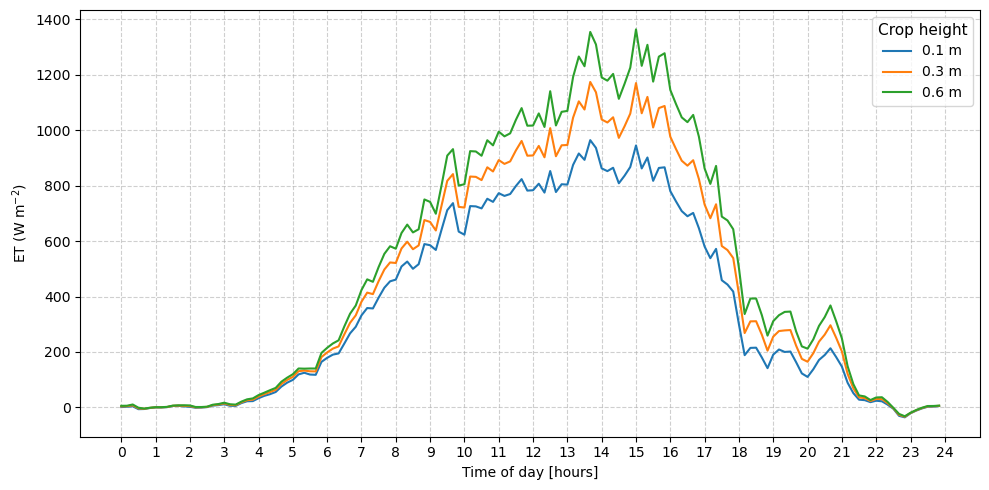

In [30]:


# Continuous time axis in hours (0–24 in 10 min steps)
time_hours = np.arange(0, 24, 10/60)   # 144 points


plt.figure(figsize=(10,5))


for idx, h in enumerate(heights):
    plt.plot(
        time_hours, ET[idx, :],
        label=f"{h:.1f} m",
        linewidth=1.5,
    )

plt.xlabel("Time of day [hours]")
plt.ylabel("ET (W m$^{-2}$)")
#plt.title("Evapotranspiration (ET) over 24h")
plt.grid(True)

# Show ticks every hour
plt.xticks(range(0, 25, 1))
plt.legend(title="Crop height", fontsize=10, title_fontsize=11, loc="upper right")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

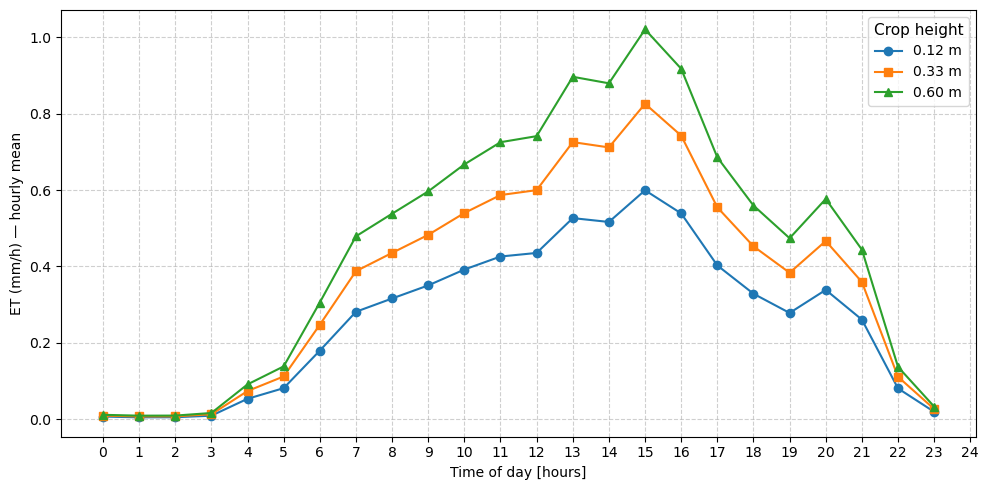

In [31]:
steps_per_hour = 6
total_hours = 24
expected_len = total_hours * steps_per_hour

# Safety: trim to whole hours if needed
ET_mm_trim = ET_mm[:, :expected_len]

# Hourly means: reshape [heights, 24, 6] → mean over the last axis
ET_mm_hourly = ET_mm_trim.reshape(len(heights), total_hours, steps_per_hour).mean(axis=2)

# Hour ticks 0..23
hours = np.arange(total_hours)

# Markers: circle, square, triangle (then cycle if more than 3 heights)
markers = ['o', 's', '^']

plt.figure(figsize=(10,5))

for idx, h in enumerate(heights):
    marker = markers[idx % len(markers)]
    plt.plot(
        hours,
        ET_mm_hourly[idx, :],
        linestyle='-',
        marker=marker,
        label=f"{h:.2f} m"
    )

plt.xticks(range(0, 25, 1))
plt.xlabel("Time of day [hours]")
plt.ylabel("ET (mm/h) — hourly mean")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Crop height", fontsize=10, title_fontsize=11, loc="upper right")
plt.tight_layout()
plt.show()

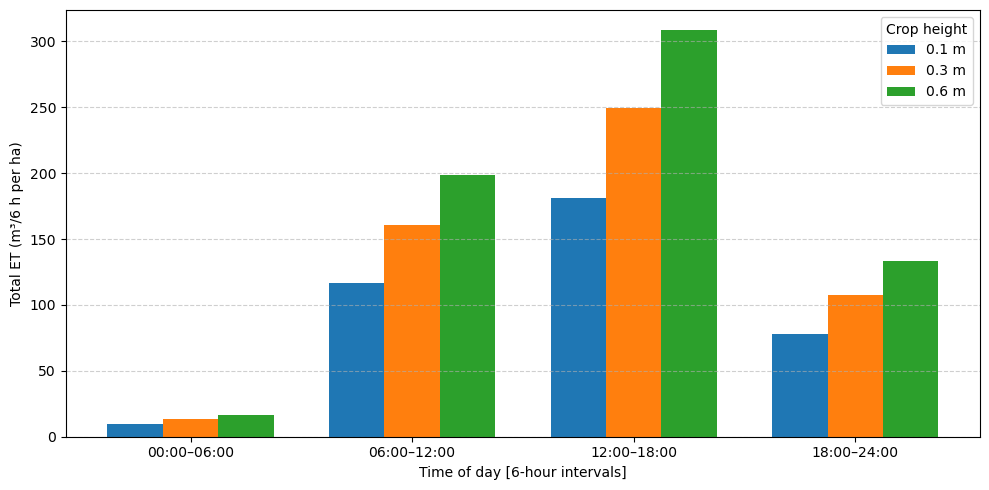

In [32]:
#Cost mm/h -> m^3/period
A= 10000 # m^2 - 1 hectar
E_m=ET_mm * A *0.001 #m^3/h


# 6-hour bin edges (0–6, 6–12, 12–18, 18–24)
bin_edges = np.arange(0, 25, 6)
bin_labels = [f"{bin_edges[i]:02.0f}:00–{bin_edges[i+1]:02.0f}:00" for i in range(len(bin_edges)-1)]

# Number of timesteps per 6 h (10 min resolution → 6*60/10 = 36 steps)
steps_per_bin = 36

ET_m3h = ET_mm * 10  # 1 ha → m³/h

# Aggregate into 6 h sums [heights × 4 bins]
ET_m3h_bins = ET_m3h.reshape(len(heights), 4, steps_per_bin).sum(axis=2)

# Plot as grouped bar chart
x = np.arange(len(bin_labels))  # positions for bins
width = 0.25  # bar width

plt.figure(figsize=(10,5))

for idx, h in enumerate(heights):
    plt.bar(
        x + idx*width,
        ET_m3h_bins[idx, :],
        width=width,
        label=f"{h:.1f} m",
    )

plt.xticks(x + width, bin_labels)
plt.xlabel("Time of day [6-hour intervals]")
plt.ylabel("Total ET (m³/6 h per ha)")
plt.legend(title="Crop height", fontsize=10)
plt.grid(True, linestyle="--", axis="y", alpha=0.6)
plt.tight_layout()
plt.show()

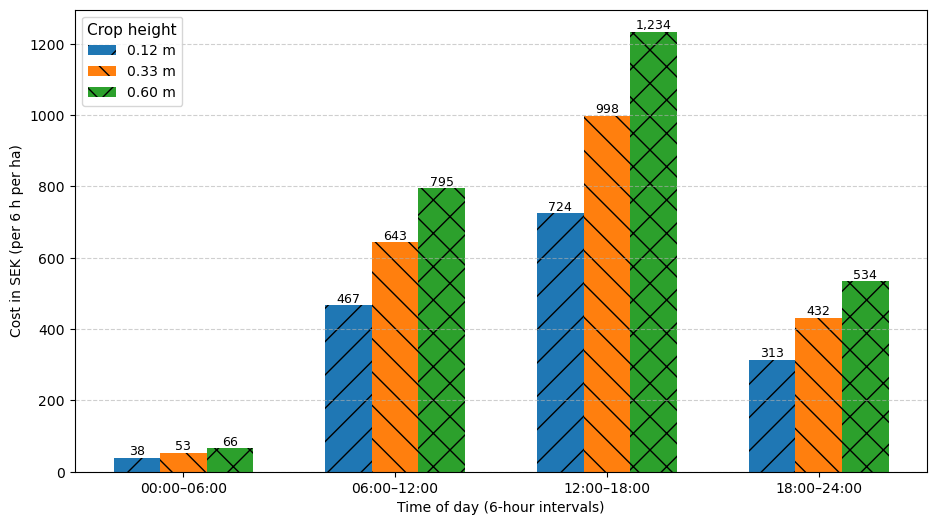

In [33]:

price_per_m3 = 4.0          # SEK per m³; set to your actual price
bar_width = 0.22            # narrower bars to leave space between groups
hatches = ['/', '\\', 'x', 'o', '.', '*']  # will cycle if more heights than patterns
label_fmt = "{:,.0f}"       # show rounded SEK with thousands sep; e.g., 12,345

# ------------------------
# Binning (6-hour blocks)
# ------------------------
bin_edges = np.arange(0, 25, 6)  # [0, 6, 12, 18, 24]
bin_labels = [f"{bin_edges[i]:02.0f}:00–{bin_edges[i+1]:02.0f}:00" for i in range(len(bin_edges)-1)]

# 10-min steps → 6 * 60 / 10 = 36 steps per 6-h bin
steps_per_bin = 36

# Convert mm/h → m³/h per hectare (1 mm/h over 1 ha = 10 m³/h)
ET_m3h = ET_mm * 10

# Aggregate into 6 h totals [heights × 4 bins]
ET_m3h_bins = ET_m3h.reshape(len(heights), 4, steps_per_bin).sum(axis=2)

# Scale and turn into cost
values = ET_m3h_bins *  price_per_m3   # units: SEK per 6 h per ha

# ------------------------
# Plot
# ------------------------
x = np.arange(len(bin_labels))       # [0,1,2,3] bin centers
group_offset = (np.arange(len(heights)) - (len(heights)-1)/2.0) * bar_width

plt.figure(figsize=(11, 6))

# Bars per height with distinct hatching (no explicit colors)
for idx, h in enumerate(heights):
    positions = x + group_offset[idx]
    bars = plt.bar(
        positions,
        values[idx, :],
        width=bar_width,
        hatch=hatches[idx % len(hatches)],
        label=f"{h:.2f} m",
        linewidth=1.0
    )
    # Add value labels on top of bars
    for r in bars:
        height = r.get_height()
        if np.isfinite(height) and height > 0:
            plt.text(
                r.get_x() + r.get_width()/2.0,
                height,
                label_fmt.format(height),
                ha='center', va='bottom',
                fontsize=9, rotation=0
            )

# X labels and ticks
plt.xticks(x, bin_labels, rotation=0)
plt.xlabel("Time of day (6-hour intervals)")

# Y label and grid
plt.ylabel("Cost in SEK (per 6 h per ha)")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)

# Legend and titles
plt.legend(title="Crop height", fontsize=10, title_fontsize=11, loc="upper left", frameon=True)


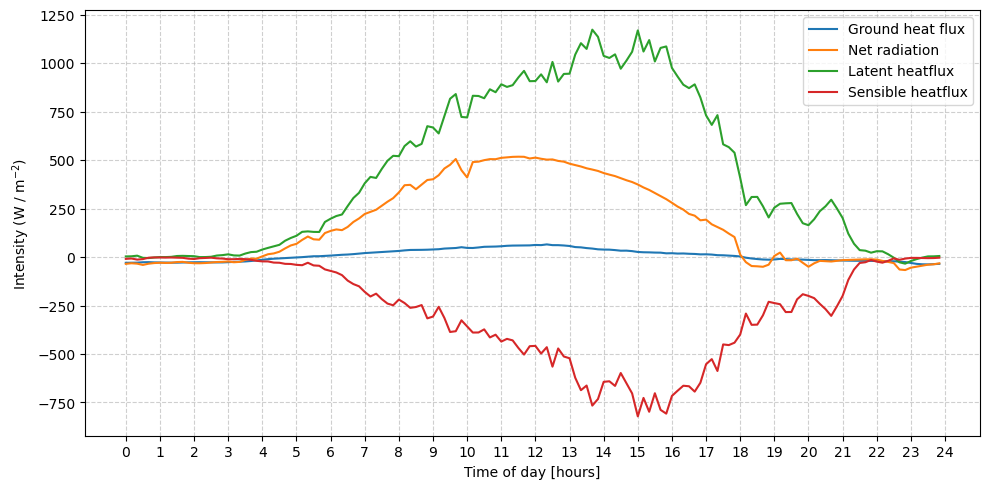

In [34]:

#For crop height 33 cm

# Continuous time axis in hours (0–24 in 10 min steps)
time_hours = np.arange(0, 24, 10/60)   # 144 points


plt.figure(figsize=(10,5))


plt.plot( time_hours, G , label= "Ground heat flux" , linewidth=1.5) #Ground heatflux
plt.plot( time_hours, R , label= "Net radiation" , linewidth=1.5) #Nett radiation
plt.plot( time_hours, ET[1,:]  , label= "Latent heatflux" , linewidth=1.5)  #Latent heat flux
plt.plot( time_hours, (R-G)-ET[1,:], label= "Sensible heatflux" , linewidth=1.5)  #Sensible heat flux

plt.xlabel("Time of day [hours]")
plt.ylabel("Intensity (W / m$^{-2}$)")

plt.grid(True)

# Show ticks every hour
plt.xticks(range(0, 25, 1))
plt.legend( fontsize=10, title_fontsize=11, loc="upper right")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()